In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M53_01_02.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_04.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_04_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_01_09.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_03_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_02_10.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_06.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_01_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_10.jpg
/kaggle/input/monkeypox-s


=== Fold 1 ===


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1/30: Train Loss: 0.3643 | Train Acc: 0.8590 | Val Loss: 0.1203 | Val Acc: 0.9562
Epoch 2/30: Train Loss: 0.1079 | Train Acc: 0.9636 | Val Loss: 0.1633 | Val Acc: 0.9358
Epoch 3/30: Train Loss: 0.0608 | Train Acc: 0.9820 | Val Loss: 0.0861 | Val Acc: 0.9797
Epoch 4/30: Train Loss: 0.0652 | Train Acc: 0.9796 | Val Loss: 0.1359 | Val Acc: 0.9531
Epoch 5/30: Train Loss: 0.0467 | Train Acc: 0.9882 | Val Loss: 0.0462 | Val Acc: 0.9844
Epoch 6/30: Train Loss: 0.0052 | Train Acc: 0.9992 | Val Loss: 0.0397 | Val Acc: 0.9922
Epoch 7/30: Train Loss: 0.0173 | Train Acc: 0.9949 | Val Loss: 0.0400 | Val Acc: 0.9922
Epoch 8/30: Train Loss: 0.0003 | Train Acc: 1.0000 | Val Loss: 0.0431 | Val Acc: 0.9922
Epoch 9/30: Train Loss: 0.0001 | Train Acc: 1.0000 | Val Loss: 0.0418 | Val Acc: 0.9922
Epoch 10/30: Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0430 | Val Acc: 0.9922
Epoch 11/30: Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0449 | Val Acc: 0.9922
Epoch 12/30: Train Loss: 0.000

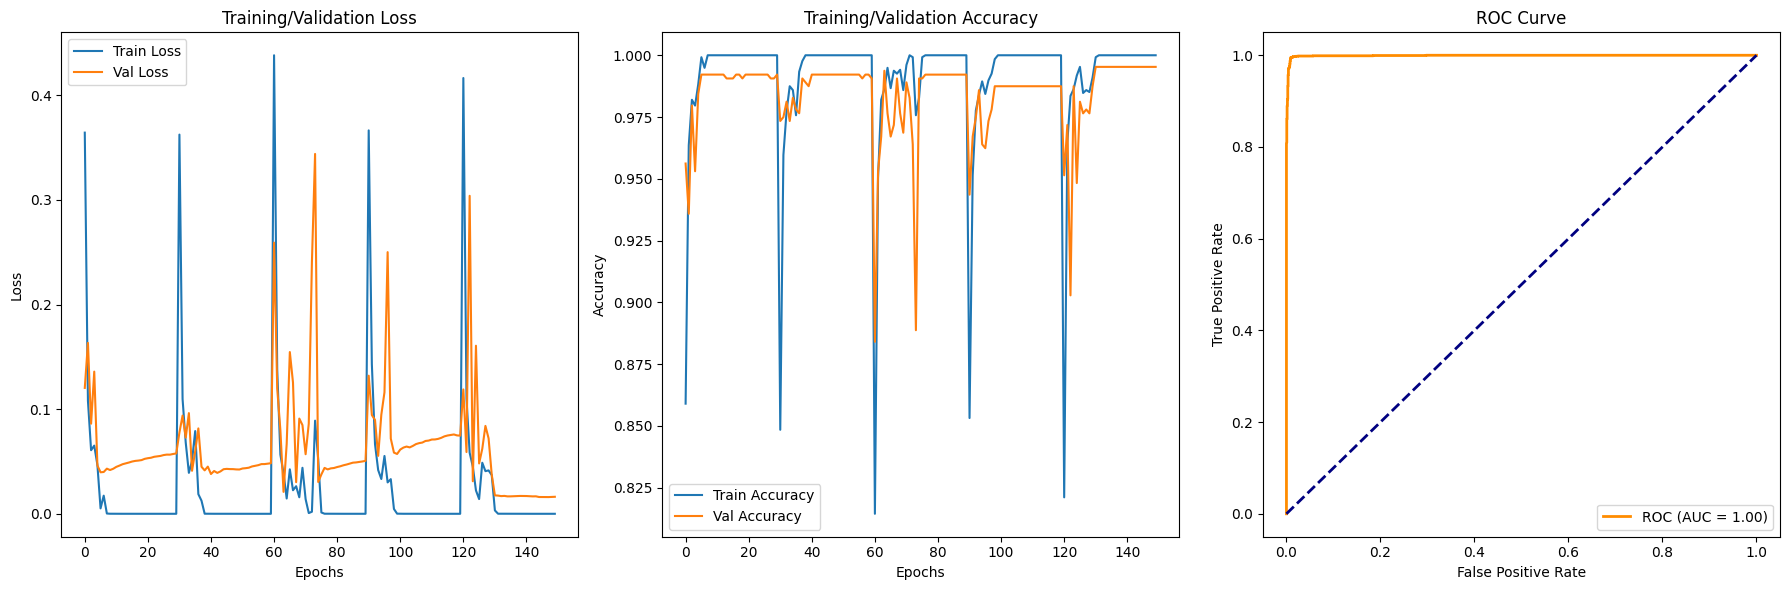

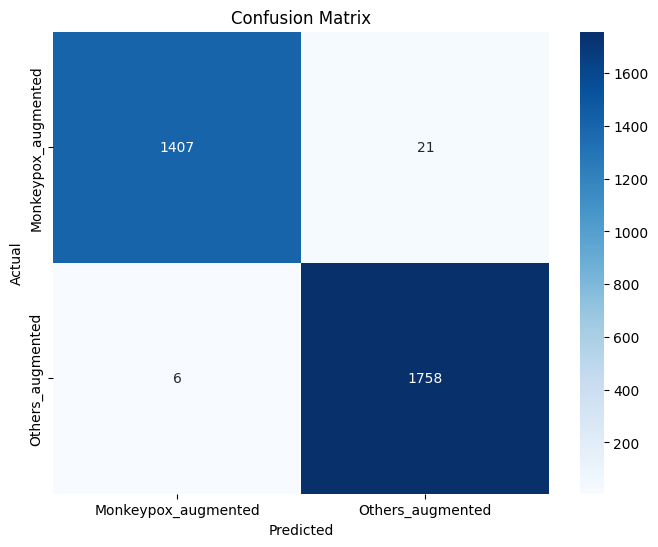


=== Final Cross-Validation Results ===
Average Accuracy: 0.9915
Average Precision: 0.9916
Average Recall: 0.9915
Average F1 Score: 0.9915


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from transformers import ViTModel
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, roc_curve, 
                            auc, confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# Initialize metric trackers
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_predictions = []
all_labels = []
all_probs = []

# Paths and parameters
folder_path = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
subfolders = ['Monkeypox_augmented', 'Others_augmented']
image_size = (224, 224)
batch_size = 16
epochs = 30
learning_rate = 0.0001
gamma = 0.5

# Image transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess dataset
data = []
labels = []
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            data.append(img)
            labels.append(label_map[subfolder])

data = np.array(data).astype("float32")
labels = np.array(labels)

# Create PyTorch datasets
data = torch.tensor(data).permute(0, 3, 1, 2) / 255.0
labels = torch.tensor(labels)
dataset = TensorDataset(data, labels)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Broad Attention Mechanism
class BroadAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(BroadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, queries, keys, values):
        queries = torch.cat(queries, dim=1)
        keys = torch.cat(keys, dim=1)
        values = torch.cat(values, dim=1)
        attention_output, _ = self.attention(queries, keys, values)
        pooled_output = self.pool(attention_output.permute(0, 2, 1)).squeeze(-1)
        return pooled_output

# BViT Model Architecture
class BViTNet(nn.Module):
    def __init__(self, vit_model_name, num_classes, gamma=0.5):
        super(BViTNet, self).__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name, output_attentions=True)
        self.hidden_size = self.vit.config.hidden_size
        self.num_layers = len(self.vit.encoder.layer)
        self.gamma = gamma
        self.broad_attention = BroadAttention(self.hidden_size, self.num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        deep_features = hidden_states[-1][:, 0, :]
        queries = [layer[:, 0, :].unsqueeze(1) for layer in hidden_states]
        broad_features = self.broad_attention(queries, queries, queries)
        combined_features = deep_features + self.gamma * broad_features
        return self.classifier(combined_features)

# Enhanced Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    epoch_train_losses, epoch_val_losses = [], []
    epoch_train_accs, epoch_val_accs = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
        
        # Calculate epoch metrics
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        epoch_train_losses.append(train_loss)
        epoch_train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        epoch_val_losses.append(val_loss)
        epoch_val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

# Enhanced Evaluation Function
def evaluate_model(model, loader):
    model.eval()
    preds, targets, probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
            probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    return {
        'accuracy': accuracy_score(targets, preds),
        'precision': precision_score(targets, preds, average='weighted'),
        'recall': recall_score(targets, preds, average='weighted'),
        'f1': f1_score(targets, preds, average='weighted'),
        'preds': preds,
        'targets': targets,
        'probs': np.array(probs)
    }

# Complete Cross-Validation Loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\n=== Fold {fold+1} ===")
    train_sub = Subset(dataset, train_idx)
    val_sub = Subset(dataset, val_idx)
    
    train_loader = DataLoader(train_sub, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=batch_size, shuffle=False)
    
    model = BViTNet("google/vit-base-patch16-224-in21k", 2, gamma).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training with metric collection
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    
    # Update global trackers
    all_train_losses.extend(train_loss)
    all_val_losses.extend(val_loss)
    all_train_accuracies.extend(train_acc)
    all_val_accuracies.extend(val_acc)
    
    # Final evaluation
    results = evaluate_model(model, val_loader)
    all_predictions.extend(results['preds'])
    all_labels.extend(results['targets'])
    all_probs.extend(results['probs'][:, 1])
    
    # Store fold results
    fold_results.append((
        results['accuracy'],
        results['precision'],
        results['recall'],
        results['f1']
    ))
    print(f"Fold {fold+1} Metrics: "
          f"Acc: {results['accuracy']:.4f} | "
          f"Prec: {results['precision']:.4f} | "
          f"Rec: {results['recall']:.4f} | "
          f"F1: {results['f1']:.4f}")

# Visualization Functions
def plot_metrics():
    plt.figure(figsize=(18, 6))
    
    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(all_train_losses, label='Train Loss')
    plt.plot(all_val_losses, label='Val Loss')
    plt.title('Training/Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(all_train_accuracies, label='Train Accuracy')
    plt.plot(all_val_accuracies, label='Val Accuracy')
    plt.title('Training/Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # ROC Curve
    plt.subplot(1, 3, 3)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix():
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=subfolders, yticklabels=subfolders)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Generate all visualizations
plot_metrics()
plot_confusion_matrix()

# Final Results
avg_results = np.mean(fold_results, axis=0)
print("\n=== Final Cross-Validation Results ===")
print(f"Average Accuracy: {avg_results[0]:.4f}")
print(f"Average Precision: {avg_results[1]:.4f}")
print(f"Average Recall: {avg_results[2]:.4f}")
print(f"Average F1 Score: {avg_results[3]:.4f}")
